In [19]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split , cross_val_score

In [2]:
con = sqlite3.connect("D:/[FCO] AppliedAICourse - Applied Machine Learning Course/1.0 CSV files/Amazon fine food reviews/database.sqlite")

#Score = 1 or 2 means review would be negative and Score = 3 or 5 means review would be positive. Hence, Score = 3 is neglected. 
data = pd.read_sql_query("""
       SELECT * from Reviews
       where Score != 3""" , con)

print(data.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [3]:
def partition(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'

actualScore = data['Score']
positiveNegative = actualScore.map(partition)
data['Score'] = positiveNegative

In [5]:
display = pd.read_sql_query("""
        SELECT * FROM Reviews 
        WHERE Score != 3 AND UserId = 'AR5J8UI46CURR'
        ORDER BY ProductId
        """ , con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = data.sort_values('ProductId' , axis = 0 , inplace = False , ascending = True)
final = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)
final.shape

(364173, 10)

In [7]:
#Keeping only those data points where HelpfulnessNumerator is greater than or equal to HelpfulnessDenominator
#as HelpfulnessNumerator cannot be greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [9]:
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr , '' , sentence)
    return cleantext

def clearpunc(sentence):
    cleaned = re.sub(r'[? | ! | \' | " | #]' , r'' , sentence)
    cleaned = re.sub(r'[. | , | ) | ( | \ | / | : | ; | < | >]' , r'' , cleaned)
    return cleaned

In [10]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
print(stop)

{'into', 'between', "weren't", 'until', "you've", 'so', 'further', 'ma', 'such', 'or', 'just', 'where', "don't", 'on', 'for', 're', "should've", 'an', 'our', 'out', 'that', 'not', 'against', 'myself', 'up', 'been', 'again', "doesn't", 'do', "you'd", 'me', 'ourselves', 'themselves', 'each', 'some', 'himself', 'than', 'was', 'doesn', 'weren', 'having', 'of', 'those', 'ours', 'why', 'both', "hasn't", 'mustn', 'after', "didn't", "shouldn't", "haven't", 'whom', 'your', 'mightn', 'before', "isn't", 'but', "wasn't", 'd', 'at', 'will', 't', 'needn', 'their', 'about', 'if', 'because', 'i', 'this', 'down', 'how', 'don', 'other', 'll', 'through', 'isn', 'haven', 'and', 's', 'yourselves', 'here', 'while', 'can', 'o', 'no', "you're", "aren't", 'all', "couldn't", 'couldn', 'should', 'y', 'during', 'won', 'doing', 'it', 'shan', "wouldn't", 'didn', 'she', 'hers', 'you', 'they', 'these', 'as', 'theirs', 'the', 'to', 'my', 'does', "needn't", 'too', 'with', 'very', 'hadn', 'by', 'we', 'm', 'a', 'most', "

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 364k sentences.
i = 0
str1 = ' '
finalString = []
all_positive_words = []
all_negative_words = []
s = ''

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleanedwords in clearpunc(w).split():
            if((cleanedwords.isalpha()) & (len(cleanedwords) > 2)):
                if(cleanedwords.lower() not in stop):
                    s = (sno.stem(cleanedwords.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                        
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                        
                else:
                    continue
            else:
                continue
                
    str1 = b" ".join(filtered_sentence)
    
    finalString.append(str1)
    i += 1

In [12]:
final['Cleaned Text'] = finalString

In [13]:
X1 = final[final['Score'] == 'positive'].sample(n = 50000 , random_state = 0)
X2 = final[final['Score'] == 'negative'].sample(n = 50000 , random_state = 0) 
X = pd.concat([X1 , X2])

In [16]:
X.shape

(100000, 11)

In [18]:
X['Time'] = pd.to_datetime(X['Time'] , unit = 's')
X = X.sort_values('Time')
X.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazyim look beatlejuic french version v...
417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,negative,2001-06-11,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,b'michael keaton bring distinguish characteris...


In [29]:
def naive_bayes(X_Train, Y_Train):
    
    """
    This function calculates the optimal alpha
    """
    
    alpha_values = np.arange(1, 500, 0.5)
    
    cv_scores = []
    
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_Train, Y_Train , cv = 10 , scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    MSE = [1-x for x in cv_scores]
    
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    
    print('The optimal value of alpha is {}'.format(optimal_alpha))
    
    plt.plot(MSE , alpha_values , marker = '^')
    plt.ylabel('alpha')
    plt.xlabel('Misclassification Error')
    plt.title('MSE vs alpha')
    plt.show()
    
    return optimal_alpha

In [21]:
x = X['Cleaned Text']
y = X['Score']
print(x.shape , y.shape)

(100000,) (100000,)


In [23]:
x_train , x_test , y_train, y_test = train_test_split(x , y, test_size = 0.3 , random_state = 40)
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [25]:
bow_nb = CountVectorizer()
x_train = bow_nb.fit_transform(x_train)
x_test = bow_nb.transform(x_test)
print(x_train.shape , x_test.shape)

(70000, 70909) (30000, 70909)


The optimal value of alpha is 7.0


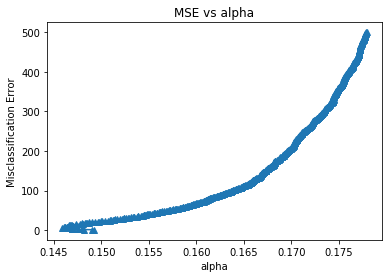

In [30]:
optimal_alpha_bow = naive_bayes(x_train , y_train)

In [31]:
nb_optimal = MultinomialNB(alpha = optimal_alpha_bow)
nb_optimal.fit(x_train , y_train)
pred = nb_optimal.predict(x_test)

In [33]:
feat_count = nb_optimal.feature_count_
feat_count.shape
feat_count

array([[ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [15.,  1.,  1., ...,  1.,  0.,  0.]])

In [34]:
log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.52475233, -12.52475233, -12.52475233, ..., -12.52475233,
        -12.39122093, -12.39122093],
       [-11.32179247, -12.33339339, -12.33339339, ..., -12.33339339,
        -12.46692478, -12.46692478]])

In [42]:
feature_prob = pd.DataFrame(log_prob , columns = bow_nb.get_feature_names())
print(feature_prob.head())
feature_prob_tr = feature_prob.T
feature_prob_tr.shape
feature_prob_tr.head()

         aaa  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri  aaaaaaahhhhhh  \
0 -12.524752                                        -12.524752     -12.524752   
1 -11.321792                                        -12.333393     -12.333393   

   aaaaaaarrrrrggghhh  aaaaaawwwwwwwwww  aaaaawher      aaaah  aaaahhhhhh  \
0          -12.391221        -12.524752 -12.391221 -12.524752  -12.391221   
1          -12.466925        -12.333393 -12.466925 -12.333393  -12.466925   

      aaaand       aaah  ...    zupreem     zurich   zweiback     zyliss  \
0 -12.524752 -12.524752  ... -12.391221 -12.524752 -12.391221 -12.391221   
1 -12.333393 -12.215610  ... -12.215610 -12.333393 -12.466925 -12.466925   

     zylitol    zylitor        zym        zzz    zzzzzzz      çelem  
0 -12.168077 -12.391221 -12.524752 -12.524752 -12.391221 -12.391221  
1 -12.466925 -12.466925 -12.110250 -12.333393 -12.466925 -12.466925  

[2 rows x 70909 columns]


,0,1
aaa,-12.524752,-11.321792
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri,-12.524752,-12.333393
aaaaaaahhhhhh,-12.524752,-12.333393
aaaaaaarrrrrggghhh,-12.391221,-12.466925
aaaaaawwwwwwwwww,-12.524752,-12.333393


In [43]:
print('Top 10 negative feature are :- \n', feature_prob_tr[0].sort_values(ascending = True)[:10])
print('Top 10 positive feature are :- \n', feature_prob_tr[1].sort_values(ascending = True)[:10])

Top 10 negative feature are :- 
 aaa             -12.524752
rightad         -12.524752
rightamazon     -12.524752
flakesplus      -12.524752
flakeskellogg   -12.524752
flakesin        -12.524752
flakescorn      -12.524752
flakescamu      -12.524752
flakesalmost    -12.524752
rightbtw        -12.524752
Name: 0, dtype: float64
Top 10 positive feature are :- 
 linzer         -12.466925
marudaizu      -12.466925
maruman        -12.466925
marutomo       -12.466925
marvelousbut   -12.466925
marxist        -12.466925
maryheinz      -12.466925
maryim         -12.466925
maryjan        -12.466925
marystextur    -12.466925
Name: 1, dtype: float64


In [45]:
train_acc = nb_optimal.score(x_train , y_train)
print('Training Accuracy :- ' , train_acc)
train_error = 1 - train_acc
print('Training Error :- ', train_error) 

Training Accuracy :-  0.8705142857142857
Training Error :-  0.12948571428571432


In [46]:
accuracy_bow = accuracy_score(y_test , pred) * 100
print('The accuracy score for alpha = {} is {}'.format(optimal_alpha_bow , accuracy_bow))

The accuracy score for alpha = 7.0 is 85.41666666666666


In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12978,  2008],
       [ 2367, 12647]], dtype=int64)

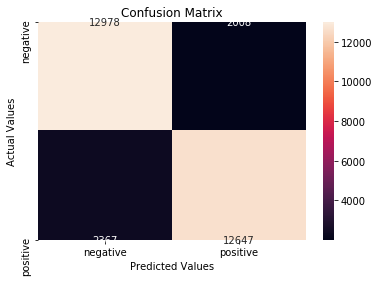

In [51]:
labels = ['negative' , 'positive']
df_cm = pd.DataFrame(cm , index = labels , columns = labels)
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86     14986
    positive       0.86      0.84      0.85     15014

    accuracy                           0.85     30000
   macro avg       0.85      0.85      0.85     30000
weighted avg       0.85      0.85      0.85     30000



In [52]:
x = X['Cleaned Text']
y = X['Score']

In [54]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.3 , random_state = 42)

In [55]:
tf_idf_nb = TfidfVectorizer(ngram_range = (1,2))
x_train = tf_idf_nb.fit_transform(x_train)
x_test = tf_idf_nb.transform(x_test)

The optimal value of alpha is 1.0


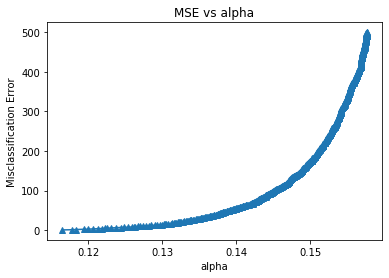

In [56]:
optimal_alpha_tfidf = naive_bayes(x_train , y_train)

In [57]:
tfidf_nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)
tfidf_nb_optimal.fit(x_train , y_train)
pred = tfidf_nb_optimal.predict(x_test)

In [59]:
log_prob = tfidf_nb_optimal.feature_log_prob_

In [62]:
log_prob_df = pd.DataFrame(log_prob , columns = tf_idf_nb.get_feature_names())
log_prob_df_tr = log_prob_df.T 
print('Top 10 negative features are :-\n' , log_prob_df_tr[0].sort_values(ascending = True)[:10])
print('Top 10 positive features are :-\n' , log_prob_df_tr[1].sort_values(ascending = True)[:10])

Top 10 negative features are :-
 zzz               -14.144376
satin bag         -14.144376
satin energi      -14.144376
satin smooth      -14.144376
satisf            -14.144376
satisf buy        -14.144376
fourth subsequ    -14.144376
satisf without    -14.144376
satisfact abl     -14.144376
satisfact admit   -14.144376
Name: 0, dtype: float64
Top 10 positive features are :-
 aa             -14.136949
lamb ear       -14.136949
lamb face      -14.136949
tree perhap    -14.136949
tree pay       -14.136949
lamb friesth   -14.136949
lamb heart     -14.136949
lamb jerkey    -14.136949
tree perk      -14.136949
lamb label     -14.136949
Name: 1, dtype: float64


In [63]:
train_acc = tfidf_nb_optimal.score(x_train , y_train)
print('Training accuracy with alpha = {} is {}'.format(optimal_alpha_tfidf , train_acc))
train_error = 1 - train_acc
print('Training error with alpha = {} is {}'.format(optimal_alpha_tfidf , train_error))

Training accuracy with alpha = 1.0 is 0.9696857142857143
Training error with alpha = 1.0 is 0.030314285714285738


In [64]:
accuracy_tfidf = accuracy_score(y_test , pred) * 100
print('The accuracy with alpha = {} is {}'.format(optimal_alpha_tfidf , accuracy_tfidf))

The accuracy with alpha = 1.0 is 88.58666666666667


In [65]:
cm = confusion_matrix(y_test , pred)
cm

array([[13303,  1700],
       [ 1724, 13273]], dtype=int64)

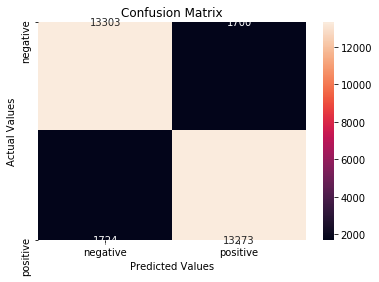

In [66]:
labels = ['negative' , 'positive']
df_cm = pd.DataFrame(cm , index = labels , columns = labels)
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [67]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89     15003
    positive       0.89      0.89      0.89     14997

    accuracy                           0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000

